# Data Exploration

In [232]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.rcParams['figure.figsize'] = (16, 9)



In [233]:
!ln -s ../utils/functions.py functions.py
from functions import get_the_original_data, get_transition_matrix

ln: functions.py: File exists


In [234]:
days = ['monday']

In [264]:
supermarket = get_the_original_data(days)
supermarket.head()

,customer_no,location
timestamp,,
2019-09-02 07:03:00,1,dairy
2019-09-02 07:03:00,2,dairy
2019-09-02 07:04:00,3,dairy
2019-09-02 07:04:00,4,dairy
2019-09-02 07:04:00,5,spices


## Calculate the total number of customers in each section

In [236]:
customers_per_section = supermarket.groupby('location').count()
customers_per_section

,customer_no
location,
checkout,1437
dairy,895
drinks,797
fruit,1005
spices,750


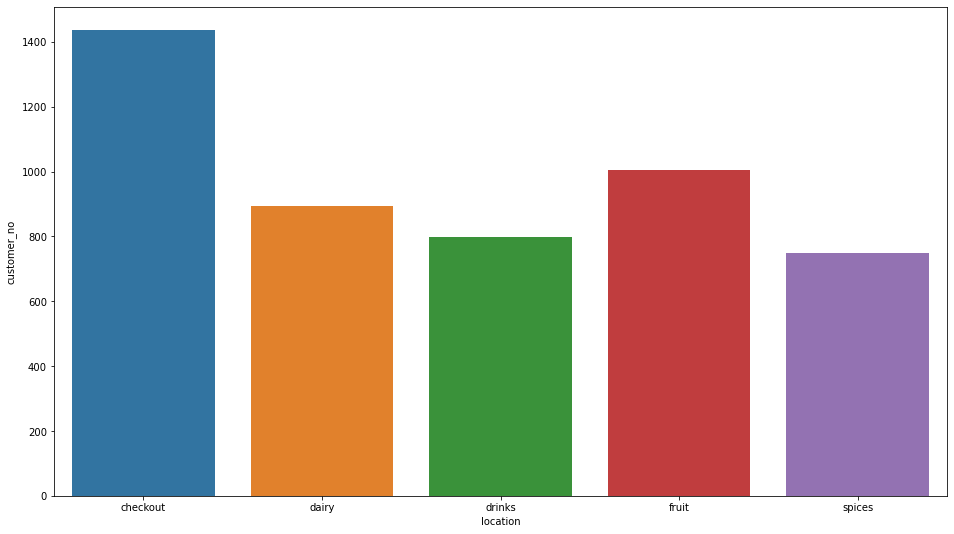

In [237]:
sns.barplot(x = customers_per_section.index, y = customers_per_section['customer_no'])

## Calculate the total number of customers in each section over time

In [238]:
supermarket.groupby(['timestamp', 'location']).count()

customer_no
timestamp           location             
2019-09-02 07:03:00 dairy               2
2019-09-02 07:04:00 dairy               2
                    fruit               1
                    spices              3
2019-09-02 07:05:00 checkout            2
...                                   ...
2019-09-02 21:49:00 dairy               1
                    fruit               2
                    spices              2
2019-09-02 21:50:00 dairy               1
                    fruit               1

[2797 rows x 1 columns]

## Display the number of customers at checkout over time

In [239]:
checkout = supermarket[supermarket.location == 'checkout'].groupby('timestamp')[['customer_no']].count()
checkout 

,customer_no
timestamp,
2019-09-02 07:05:00,2
2019-09-02 07:06:00,2
2019-09-02 07:07:00,1
2019-09-02 07:08:00,3
2019-09-02 07:09:00,1
...,...
2019-09-02 21:44:00,1
2019-09-02 21:46:00,1
2019-09-02 21:47:00,2


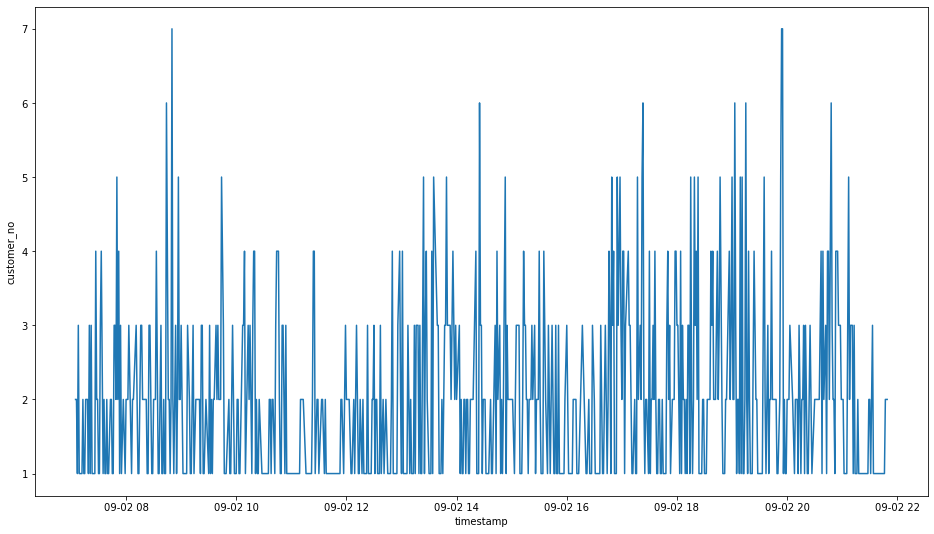

In [240]:
sns.lineplot(x = checkout.index, y = checkout.customer_no)

In [241]:
# This is super crowded so I will downsample to the hour
checkout_downsample_hour = checkout.resample('h').sum()
checkout_downsample_hour

,customer_no
timestamp,
2019-09-02 07:00:00,92
2019-09-02 08:00:00,112
2019-09-02 09:00:00,85
2019-09-02 10:00:00,90
2019-09-02 11:00:00,55
2019-09-02 12:00:00,73
2019-09-02 13:00:00,120
2019-09-02 14:00:00,90
2019-09-02 15:00:00,94


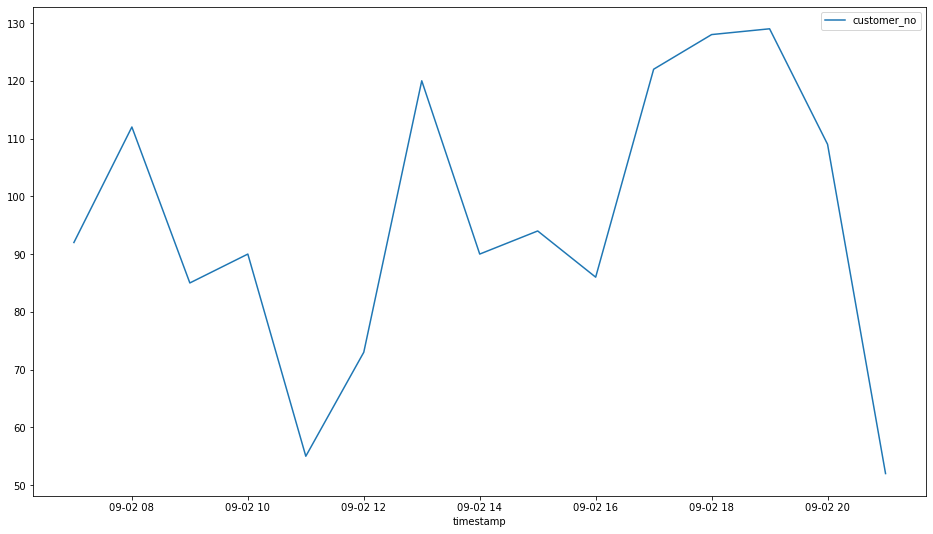

In [242]:
sns.lineplot(data = checkout_downsample_hour)

## Calculate the time each customer spent in the market

In [243]:
entry_time = supermarket.copy().reset_index().groupby('customer_no')['timestamp'].min()
exit_time = supermarket.copy().reset_index().groupby('customer_no')['timestamp'].max()
time_spent = pd.DataFrame(exit_time - entry_time).reset_index()
time_spent['time_spent'] = time_spent['timestamp'].astype(int)/ 60_000_000_000
time_spent

,customer_no,timestamp,time_spent
0,1,00:02:00,2.0
1,2,00:03:00,3.0
2,3,00:02:00,2.0
3,4,00:04:00,4.0
4,5,00:01:00,1.0
...,...,...,...
1442,1443,00:01:00,1.0
1443,1444,00:01:00,1.0
1444,1445,00:00:00,0.0
1445,1446,00:00:00,0.0


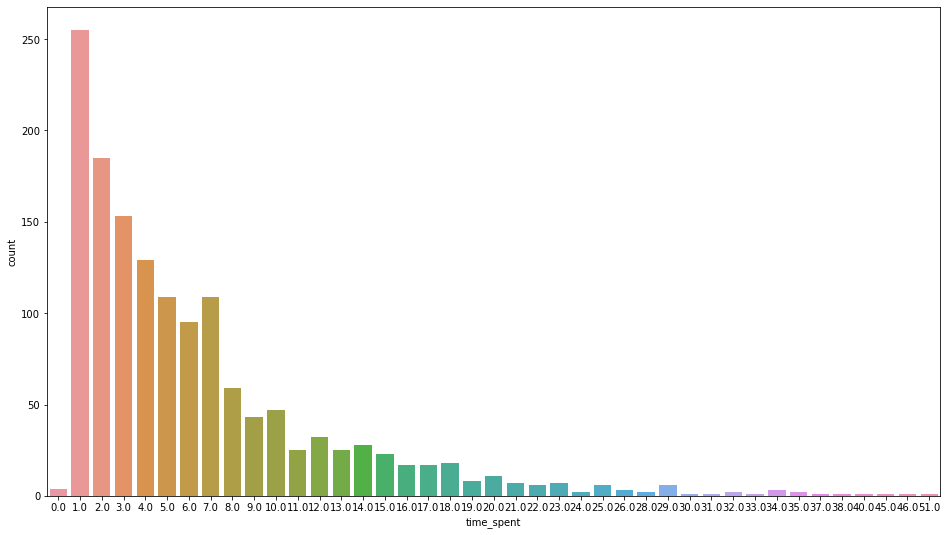

In [244]:
sns.countplot(x = 'time_spent', data = time_spent)

## Calculate the total number of customers in the supermarket over time

In [245]:
people_in_the_market_over_time = supermarket.groupby('timestamp').count()[['customer_no']]
people_in_the_market_over_time.columns = ['number_of_customers']
people_in_the_market_over_time.head()

,number_of_customers
timestamp,
2019-09-02 07:03:00,2
2019-09-02 07:04:00,6
2019-09-02 07:05:00,4
2019-09-02 07:06:00,8
2019-09-02 07:07:00,4


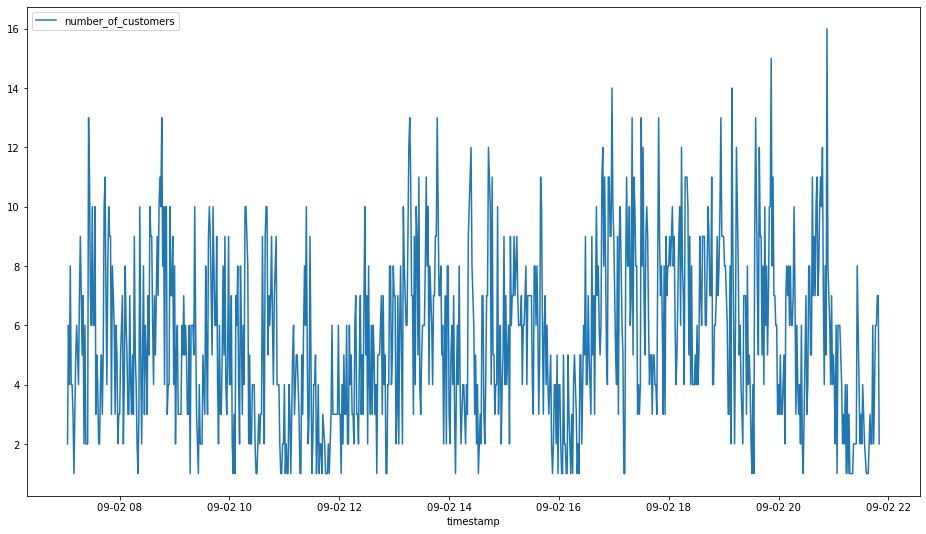

In [246]:
sns.lineplot(data=people_in_the_market_over_time)

## Our buiness managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first als "following")

In [265]:
sections_visited = supermarket.copy()
sections_visited['first'] = ~sections_visited.duplicated('customer_no')
sections_visited.head(10)

,customer_no,location,first
timestamp,,,
2019-09-02 07:03:00,1,dairy,True
2019-09-02 07:03:00,2,dairy,True
2019-09-02 07:04:00,3,dairy,True
2019-09-02 07:04:00,4,dairy,True
2019-09-02 07:04:00,5,spices,True
2019-09-02 07:04:00,6,spices,True
2019-09-02 07:04:00,7,spices,True
2019-09-02 07:04:00,8,fruit,True
2019-09-02 07:05:00,1,checkout,False


In [271]:
first_visited = sections_visited[sections_visited['first']].groupby('location')[['customer_no']].count()
follow_visited = sections_visited[~sections_visited['first']].groupby('location')[['customer_no']].count()

In [298]:
first_visited_normalized = first_visited.copy()
first_visited_normalized.customer_no = first_visited_normalized.customer_no / (first_visited_normalized.customer_no).sum()
first_visited_normalized

,customer_no
location,
dairy,0.284727
drinks,0.160332
fruit,0.359364
spices,0.195577


In [303]:
follow_visited_normalized = follow_visited.copy()
follow_visited_normalized.customer_no = follow_visited.customer_no / (follow_visited.customer_no).sum()
follow_visited_normalized

,customer_no
location,
checkout,0.418097
dairy,0.140530
drinks,0.164388
fruit,0.141111
spices,0.135874


In [305]:
visted_locations = follow_visited_normalized.copy()
visted_locations.columns = ['follow']
visted_locations['first'] = first_visited_normalized
visted_locations

,follow,first
location,,
checkout,0.418097,NaN
dairy,0.140530,0.284727
drinks,0.164388,0.160332
fruit,0.141111,0.359364
spices,0.135874,0.195577


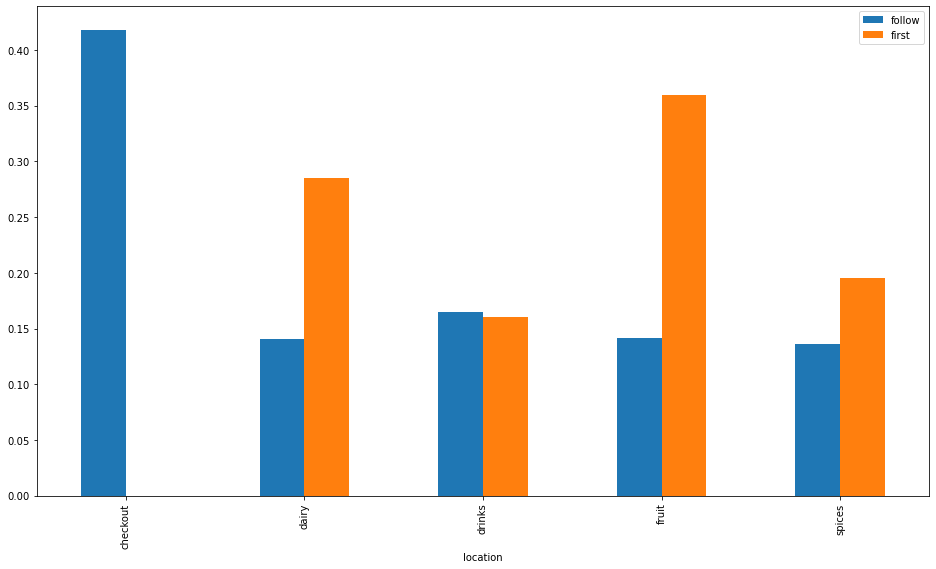

In [314]:
visted_locations.plot.bar()

In [250]:
get_transition_matrix(supermarket)

next_isle,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.347924,0.000000,0.244669,0.202020,0.205387
drinks,0.534504,0.028858,0.000000,0.233375,0.203262
fruit,0.523477,0.224775,0.129870,0.000000,0.121878
spices,0.236631,0.314171,0.290107,0.159091,0.000000


In [261]:
get_transition_matrix(first_visited)

""


In [262]:
get_transition_matrix(follow_visited)

next_isle,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.349272,0.000000,0.216216,0.237006,0.197505
drinks,0.536283,0.010619,0.000000,0.237168,0.215929
fruit,0.517598,0.209110,0.140787,0.000000,0.132505
spices,0.227957,0.333333,0.268817,0.169892,0.000000


In [253]:
first_visited = sections_visited[sections_visited['first']]
transition_matrix = pd.crosstab(first_visited['location'], first_visited['next_aisle'], normalize=0)
transition_matrix

next_aisle,checkout,dairy,drinks,fruit,spices
location,,,,,
dairy,0.346341,0.000000,0.278049,0.160976,0.214634
drinks,0.530172,0.073276,0.000000,0.224138,0.172414
fruit,0.528958,0.239382,0.119691,0.000000,0.111969
spices,0.250883,0.282686,0.325088,0.141343,0.000000
